# Proyecto Machine Learning ==> Inmigracion en Chile
## Magister en Data Science - 2o. Trim. 2018 

**Profesor:** Graells-Garrido, E.<br>
**Alumnos:** Briceno, H.; Rovai, M.; Tessada G.
<p>Santiago, 06 de Noviembre 2018

---
## Pregunta:
### En cuales comunas se concentran los inmigrantes que llegaron a la Región Metropolitana? Quien son? Como són? Y los nuevos, donde viverán?
---

## Introdución

<p><img src="./images/01_limp_data.png"></p>

Para la generación del dataset del proyecto, se trabajó con datos de la base de datos del [Departamento de Extranjeria y Migracion de Chile](http://www.extranjeria.gob.cl/estadisticas-migratorias/). 

El Departamanto de Extranjeria y Migracion de Chile, aclara que si bien las bases se presentan de manera separada por tratarse de distintos tipos de permiso, ellas no constituyen universos distintos de inmigrantes. Un inmigrante en Chile para obtener una permanencia definitiva DEBE haber obtenido con anterioridad una visa, por lo que las bases de permanencias definitivas se conforman de personas que están contabilizadas en las visas. <br>
<br>Así, para una mejor lectura de los datos haremos una distinción en términos de migración transitoria y migración permanente. Se considerará que las visas corresponden a migración transitoria, pues los permisos duran entre uno y dos años. Las personas que sean titulares de una visa, para quedarse por un plazo mayor a dos años, deben solicitar un permiso de permanencia definitiva, de otra manera deben abandonar el país.<br>
- En este trabajo focaremos en la MIGRACIÓN DEFINITIVA, que están relacionadas a las Permisos de Residencia Definitiva
- Y se complementará esa información con la migración reciente, es decir, las visas otorgadas los dos últimos años (2017/2018).

**Información Registrada**<br>
Las planillas de permisos migratorios contienen los siguientes datos, los cuales son extraídos de los formularios establecidos para solicitar residencia, disponibles en la página web del Departamento de Extranjería y Migración:
- Sexo
- Fecha de nacimiento
- Actividad (*): refiere a la actividad que el extranjero declara realizar en nuestro país. 
- Profesión (*): refiere a la profesión que el extranjero declara al momento de realizar su solicitud.
- País
- Estudios (*): refiere al nivel de estudios que el migrante declara al momento de realizar su solicitud. 
- Comuna (*):corresponde a la comuna de residencia que declara el inmigrante al momento de realizar su solicitud y no da cuenta necesariamente de la actual residencia del extranjero
- Provincia (*): corresponde a la provincia de residencia que declara el inmigrante al momento de realizar su solicitud y no da cuenta necesariamente de la actual residencia del extranjero
- Región (*): corresponde a la región de residencia que declara el inmigrante al momento de realizar su solicitud y no da cuenta necesariamente de la actual residencia del extranjero
- Tit – Dep: se refiere a la categoría TITULAR del permiso migratorio otorgado o DEPENDIENTE en el caso que el permiso es otorgado a un familiar directo, y el dependiente lo acompaña en su residencia en Chile.
- Año: se refiere al año en que se otorga el permiso migratorio
- Beneficio: referido al permiso de residencia otorgado (tipo de visa según categoría legal: estudiante, sujeta a contrato, temporaria)

(*) Se trata de una variable con moderada tasa de registro, por lo que se sugiere utilizar con cautela la información que ella arroja. Ademas, por tratarse de información autodeclarada no se presentan medios de verificación

#### NOTA:
Hasta el presente momento, el INE no entrega datos detallados del Censo 2017 en lo que corresponde a los extranjeros, sendo los dados públicos consolidados por manzanas y no por casas ("households"). Por esto, se optó por trabajar con los datos del IME. Así, es importnate apuntar, que los numeros finales no són una fotografia de los inmigrantes en Chile, pero una muy buena representación y tendencias. Además, en un análisis adicional, se puede confirmar que el dataset generado, al menos en termino de cantidad de extrajeros por comunas, tiene un alto grade de correlación con los datos del Censo 2017, esta correlacion es un indicio bastante fuerte de que los resultados encontrados en el dataset final son bastante confiables.  

---

### El dataset limpio

La base de datos "limpía", se obtuvo a partir del notebook, desarrollado para el tramo 'Analisis de Datos': 
- 01-Limpieza-Enriquecimiento.ipynb

<p><img src="./images/04_ML.png"></p>

**Información constante del dataset limpio:** <br>
- PAIS  - (País de origen)
- SEXO	
- EDAD - (la edad en el año que recibió el benefício)
- ESTUDIOS	
- ACTIVIDAD	
- PROFESION
- BENEFICIO - (Visa temporária o definitiva)
- TIT_DEP - (El que recibe el benefício es Titular o Dependente)
- ANIO - (año en que recibió el benefício)
- COMUNA

---

`En las etapas 1 a 9 de este notebook, se proceederá con el pre-procesamiento y preparación de la data para uso por los modelos de ML.`

**Importación de las principales librerias**

In [117]:
import pandas as pd
import numpy as np
from scipy import interp
from itertools import cycle

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.metrics import accuracy_score

from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ClassPredictionError

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  

import warnings
warnings.filterwarnings("ignore")

**Definición de parametros dgeneral de las gráficas**

In [2]:
sns.set(style="whitegrid", palette="pastel", color_codes=True);
sns.mpl.rc("figure", figsize=(8,6));
plt.figure(figsize = (8,8)); 

**Funciones especiales para evaluación visual de los modelos**

In [3]:
def multiclass_roc_auc_score(title, score, y_test, y_pred, average="macro"):
    lb = preprocessing.LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

In [4]:
def roc_multiclass (title, score, y_pred, y_test):

    n_classes=5
    nb = score
    pred1 = y_pred
    t1=sum(x==0 for x in pred1 - y_test) / len(pred1)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(y_test))[:, i], np.array(pd.get_dummies(pred1))[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    lw=2
    plt.figure(figsize=(8,5))
    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='green', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--',color='red', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.annotate('Random Guess',(.5,.48),color='red')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC - ' + title)
    plt.legend(loc="lower right")

In [5]:
def confusion_matrix_report(y_test, y_pred, classes):
    mat = confusion_matrix(y_test, y_pred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, linewidth=1,
                xticklabels=com.classes_, yticklabels=classes)

    plt.xlabel('categoría real')
    plt.ylabel('predicción');

In [6]:
def seleccion_visual_modelo_report(X_train, y_train, X_test, y_test, model, classes):   
    
    visualizer = ClassificationReport(model, classes=classes, support=True)
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.poof()

In [7]:
def seleccion_visual_modelo_error(X_train, y_train, X_test, y_test, model, classes):

    visualizer = ClassPredictionError(model, classes=classes, support=True)
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.poof()

---

### 1. Importar el Dataset

In [8]:
!ls ./data

01_extranjeros_rm.xlsx                PDs_2018_1.xlsx
CENSO_2017_COMUNAS_RM.xlsx            Visas-2017.xlsx
Comunas_RM_Mapas_Vectoriales          Visas-2018_1.xlsx
ML_extranjeros_rm.xlsx                censo_2017_RM.xlsx
PDs-2005-2016.xlsx                    censo_2017_inmigrantes_rm_comuna.xlsx
PDs-2017.xlsx


In [9]:
df = pd.read_excel('./data/01_extranjeros_rm.xlsx')
df.shape

(589106, 10)

In [10]:
df.head(2)

,PAIS,SEXO,EDAD,ESTUDIOS,ACTIVIDAD,PROFESION,BENEFICIO,TIT_DEP,ANIO,COMUNA
0,peru,femenino,32,no informa,empleado,matrona,definitiva,t,2006,santiago
1,ecuador,masculino,58,no informa,empleado,ingeniero,definitiva,t,2007,providencia


### 2. Reducir el dadaset a titulares mayores que 18 años y menores que 85

`La idea es trabajar con los extranjeros que llegan al pais que tengan poder de decision a cerca de donde van a vivir. Para esto, basado en las análisis de los datos (notebook '02-Analisis-Datos.ipynb'), haremos un filtro en titulares entre 18 y 85 años. No se hará distinción entre los diferentes benefícios: Definitivo y/o Temporário.`

In [11]:
df = df[(df.TIT_DEP == 't') & (df.EDAD >=18) & (df.EDAD < 85)]

In [12]:
df.reset_index(drop = True, inplace=True)
df.head(2)

,PAIS,SEXO,EDAD,ESTUDIOS,ACTIVIDAD,PROFESION,BENEFICIO,TIT_DEP,ANIO,COMUNA
0,peru,femenino,32,no informa,empleado,matrona,definitiva,t,2006,santiago
1,ecuador,masculino,58,no informa,empleado,ingeniero,definitiva,t,2007,providencia


In [13]:
len(df.PROFESION.unique())

613

`Como profesion, se observa que hay un numero muy grande de diferentes valores (613), por lo que denota que no existe critério para la captura de este dato. Esta característica, dada su disperción, no nos parece útil en la preparación de la data para ML y deberá ser deletada.`

### 3. Selecionar las columnas de interes

In [14]:
df = df[['PAIS', 'SEXO', 'EDAD', 'ESTUDIOS', 'ACTIVIDAD', 'ANIO', 'COMUNA']]

In [15]:
df.head()

,PAIS,SEXO,EDAD,ESTUDIOS,ACTIVIDAD,ANIO,COMUNA
0,peru,femenino,32,no informa,empleado,2006,santiago
1,ecuador,masculino,58,no informa,empleado,2007,providencia
2,brasil,masculino,27,no informa,empresario,2008,las condes
3,bolivia,femenino,55,no informa,empresario,2007,lampa
4,el salvador,femenino,41,no informa,inactivo,2007,santiago


### 4. Reducir el numero de categorias encontrado en PAIS. 
`Definamos 20 categorías para pais de origen, definindo labels especificos que contengan 97% extranjeros y un label "otros'`

In [16]:
def simplificaPais(text):
    text = text.split(' ')
    if 'peru' in text: text = 'peru'
    elif 'venezuela' in text: text= 'venezuela'
    elif 'haiti' in text: text= 'haiti'
    elif 'colombia' in text: text= 'colombia'
    elif 'bolivia' in text: text= 'bolivia'
    elif 'argentina' in text: text= 'argentina'
    elif 'ecuador' in text: text= 'ecuador'
    elif 'china' in text: text= 'china'
    elif "espana" in text: text= "espana"
    elif 'brasil' in text: text= 'brasil'
    elif 'dominicana' in text: text= 'dominicana'
    elif 'cuba' in text: text= 'cuba'
    elif 'estados' in text: text= 'eua'
    elif 'uruguay' in text: text= 'uruguay'
    elif 'mexico' in text: text= 'mexico'
    elif 'francia' in text: text= 'francia'
    elif 'paraguay' in text: text= 'paraguay'
    elif 'alemania' in text: text= 'alemania'
    elif 'italia' in text: text= 'italia'
    else: text = 'otros'
    return text 

In [17]:
df['PAIS'] = df.PAIS.apply(simplificaPais)

In [18]:
df.PAIS.value_counts()

peru          133874
venezuela     108842
haiti          77039
colombia       60867
bolivia        16161
argentina      15940
ecuador        15048
otros          13406
china           8736
espana          8182
brasil          7042
dominicana      5909
cuba            5458
eua             3914
uruguay         2898
mexico          2828
francia         2440
paraguay        1674
alemania        1565
italia          1541
Name: PAIS, dtype: int64

### 5. Converter variables continuas en categoricas

In [19]:
df['EDAD'].describe()

count    493364.000000
mean         34.019740
std          10.150718
min          18.000000
25%          27.000000
50%          32.000000
75%          39.000000
max          84.000000
Name: EDAD, dtype: float64

`En terminos de edad, lo que se procura acá es dividir los extranjeros entre los jovenes que vienen a procura de empezar su vida profesional; los adultos que ya llegan con una vida y/o profesion consolidada y los jubilados.`

In [20]:
df['EDAD'] = pd.cut(df['EDAD'], 
                      bins = [17, 39, 65, 120],
                      labels = ['18-39', '40-64', '65+'])

In [21]:
df.EDAD.value_counts()

18-39    373471
40-64    115014
65+        4879
Name: EDAD, dtype: int64

`En relación al año en que el extranjero obtuvo su benefício se considera los extranjeros que llegaron pré/pós terremoto de 2010 y los del "boom" inmigratório de los últimos años.`

In [22]:
df['ANIO'] = pd.cut(df['ANIO'], 
                      bins = [2004, 2010, 2017, 2019],
                      labels = ['2005-09', '2010-16', '2017+'])

In [23]:
df.ANIO.value_counts()

2010-16    303863
2017+      126109
2005-09     63392
Name: ANIO, dtype: int64

In [24]:
df.sample(5)

,PAIS,SEXO,EDAD,ESTUDIOS,ACTIVIDAD,ANIO,COMUNA
211552,haiti,femenino,40-64,medio,empleado,2010-16,estacion central
63369,peru,femenino,40-64,basico,empleado,2005-09,recoleta
467606,venezuela,masculino,18-39,universitario,empleado,2017+,nunoa
454125,peru,femenino,18-39,medio,empleado,2017+,lo barnechea
171432,peru,masculino,40-64,no informa,empleado,2010-16,san joaquin


### 6. Reducir el numero de clases para COMUNA. 

`COMUNA será nuestra variable dependente (y),pues la idea es predicir donde vivería un extranjero que llega a región Metropoitana. La RM posue 52 comunas, las cuales deberán ser agrupadas en clusters (sectores). En la análisis de los datos se observó que en general los extranjeros se quedan en subregiones, por lo tanto reduciremos COMUNA a 6 clases:`
- centro
- poniente 
- oriente 
- sureste
- sur
- norte

**El mapa abajo, muestra como estarán distribuídas las comunas:**

<p><img src="./images/RM_comunas.png"></p>

In [25]:
def clusterRM(text):
    centro = ['santiago']
    oriente = ['providencia', 'vitacura', 'lo barnechea', 'las condes', 'la reina', 'nunoa']
    sureste = ['san jose de maipo', 'macul', 'la florida', 'penalolen',]
    sur = ['alhue', 'calera de tango', 'buin', 'isla de maipo', 'el bosque', 'paine', 'la granja', 'pedro aguirre cerda', 'lo espejo', 'puente alto', 'san joaquin', 'san miguel', 'pirque', 'san bernardo', 'san ramon', 'la cisterna', 'talagante', 'la pintana', ]
    norte = ['tiltil', 'renca', 'quinta normal', 'cerro navia', 'lampa', 'conchali', 'recoleta', 'independencia', 'colina', 'huechuraba', 'quilicura', ]
    poniente = ['san pedro', 'maria pinto', 'el monte', 'curacavi', 'padre hurtado', 'melipilla', 'estacion central', 'maipu', 'lo prado', 'pudahuel', 'penaflor', 'cerrillos', ]
    if   text in centro:  text = 'centro'
    elif text in oriente: text = 'oriente'
    elif text in sureste: text = 'sureste'
    elif text in sur:     text = 'sur'
    elif text in norte:   text = 'norte'
    elif text in poniente: text = 'poniente'
    else: text = 'otras'
    return text 

In [26]:
data = df.copy()

In [27]:
data['COMUNA'] = data.COMUNA.apply(clusterRM)

In [28]:
data.COMUNA.value_counts()

centro      139020
norte       116910
oriente      83530
sur          64173
poniente     63063
sureste      26668
Name: COMUNA, dtype: int64

In [29]:
data.sample(5)

,PAIS,SEXO,EDAD,ESTUDIOS,ACTIVIDAD,ANIO,COMUNA
256061,cuba,femenino,18-39,tecnico,empleado,2010-16,oriente
60593,espana,femenino,18-39,no informa,inactivo,2005-09,centro
479364,venezuela,masculino,18-39,universitario,empleado,2017+,sureste
370599,peru,femenino,18-39,medio,empleado,2010-16,norte
26031,peru,femenino,40-64,no informa,inactivo,2005-09,oriente


In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493364 entries, 0 to 493363
Data columns (total 7 columns):
PAIS         493364 non-null object
SEXO         493364 non-null object
EDAD         493364 non-null category
ESTUDIOS     493364 non-null object
ACTIVIDAD    493364 non-null object
ANIO         493364 non-null category
COMUNA       493364 non-null object
dtypes: category(2), object(5)
memory usage: 19.8+ MB


### 7. Codificar variable target (COMUNA) con Label Encoder

In [31]:
com = LabelEncoder() 
data['COMUNA'] = com.fit_transform(data.COMUNA)

In [32]:
classes = com.classes_
classes

array(['centro', 'norte', 'oriente', 'poniente', 'sur', 'sureste'],
      dtype=object)

In [33]:
data.head()

,PAIS,SEXO,EDAD,ESTUDIOS,ACTIVIDAD,ANIO,COMUNA
0,peru,femenino,18-39,no informa,empleado,2005-09,0
1,ecuador,masculino,40-64,no informa,empleado,2005-09,2
2,brasil,masculino,18-39,no informa,empresario,2005-09,2
3,bolivia,femenino,40-64,no informa,empresario,2005-09,1
4,otros,femenino,40-64,no informa,inactivo,2005-09,0


### 8. Codificar las demás variables categoricas como numéricas

`La variable SEXO será codificada como numerica binária, con "Label Encoder".` 

In [34]:
sex = LabelEncoder() 
data['SEXO'] = sex.fit_transform(data.SEXO)

`Para las demás, como la ordenen no tiene mucho sentido, se trabajará con la técnica de "One Hot Encoder".`

In [35]:
data = pd.concat([data, pd.get_dummies(data.PAIS)], axis = 1)

In [36]:
data = pd.concat([data, pd.get_dummies(data.EDAD)], axis = 1)
data = pd.concat([data, pd.get_dummies(data.ESTUDIOS)], axis = 1)
data = pd.concat([data, pd.get_dummies(data.ACTIVIDAD)], axis = 1)
data = pd.concat([data, pd.get_dummies(data.ANIO)], axis = 1)

`Las columnas originales deben ser deletadas, como también la columna 'otros' que fue generada, pues en caso de que un extranjero no sea de ningún de los 19 paises (todas columnas en cero), el será obrigatóriamente de 'otros'` 

In [37]:
del data['PAIS']
del data['EDAD']
del data['ESTUDIOS']
del data['ACTIVIDAD']
del data['ANIO']

In [38]:
del data['otros']

In [39]:
data.head()

,SEXO,COMUNA,alemania,argentina,bolivia,brasil,china,colombia,cuba,dominicana,...,empresario,estudiante,inactivo,jubilado,no_informa,obrero,religioso,2005-09,2010-16,2017+
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1,2,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
3,0,1,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0


### 9. Dividir la data, separando la variable target

In [40]:
X = data.copy()
y = X.pop('COMUNA').values

In [41]:
y

array([0, 2, 2, ..., 1, 1, 1])

In [42]:
X.head(2)

,SEXO,alemania,argentina,bolivia,brasil,china,colombia,cuba,dominicana,ecuador,...,empresario,estudiante,inactivo,jubilado,no_informa,obrero,religioso,2005-09,2010-16,2017+
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


### 10. Testando vários modelos de ML

En se tratando de clasificación se hará testes con los seguintes modelos:
- Naive Bayes
- Decision Trees
- Randon Forest
- Logistic Regression
- Linear support vector Classificator

### NAIVE BAYES

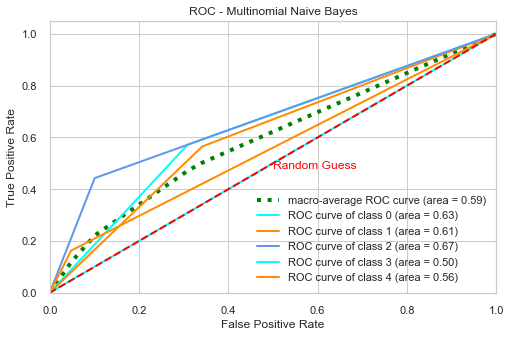

In [43]:
title = 'Multinomial Naive Bayes'
model = MultinomialNB()
SPLIT = 0.3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=SPLIT)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc_score = accuracy_score(y_test, y_pred)

roc_aus = multiclass_roc_auc_score(title, acc_score, y_test, y_pred)
roc_multiclass (title, acc_score, y_pred, y_test)

`A pesar de parecer que se obtuve un case 60% en la curva ROC, no es bien verdad, pues los datos están con siesgo (muy desbalanceados). Esto se puede confirmar en las graficas abajo:`

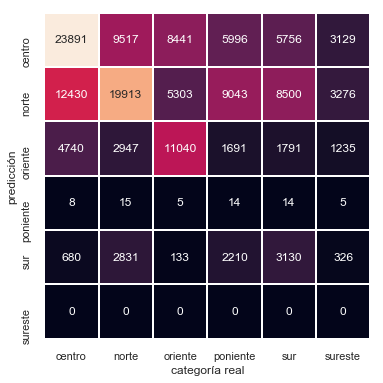

In [44]:
confusion_matrix_report(y_test, y_pred, classes)

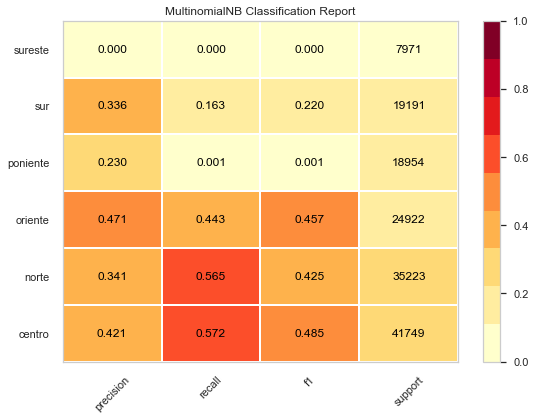

In [46]:
seleccion_visual_modelo_report(X_train, y_train, X_test, y_test, model, classes)

`Lo que se hay que hacer es balancear los datos antes de hacer testes con otros modelos.`

## Balanceando las clases

In [47]:
data.COMUNA.value_counts()

0    139020
1    116910
2     83530
4     64173
3     63063
5     26668
Name: COMUNA, dtype: int64

`Como observado anteriormente, hay un sesgo importante por cuenta de la comuna "0" (Santiago) y muy pocos datos para la "5" (Sureste). Se podría hacer un "resampling, creando mas data para sureste o dividir la comunas del setor entre 'Oriente y Sur'. Usaremos la segunda opción, pues con esto vamos tambien reducir el número de las clases, lo que podrá mejorar el resultado.` 

In [48]:
def clusterRM_2(text):
    centro = ['santiago']
    oriente = ['providencia', 'vitacura', 'lo barnechea', 'las condes', 'la reina', 'penalolen', 'nunoa']
    sur = ['san jose de maipo', 'macul', 'la florida', 'alhue', 'calera de tango', 'buin', 'isla de maipo', 'el bosque', 'paine', 'la granja', 'pedro aguirre cerda', 'lo espejo', 'puente alto', 'san joaquin', 'san miguel', 'pirque', 'san bernardo', 'san ramon', 'la cisterna', 'talagante', 'la pintana', ]
    norte = ['tiltil', 'renca', 'quinta normal', 'cerro navia', 'lampa', 'conchali', 'recoleta', 'independencia', 'colina', 'huechuraba', 'quilicura', ]
    poniente = ['san pedro', 'maria pinto', 'el monte', 'curacavi', 'padre hurtado', 'melipilla', 'estacion central', 'maipu', 'lo prado', 'pudahuel', 'penaflor', 'cerrillos', ]
    if   text in centro:  text = 'centro'
    elif text in oriente: text = 'oriente'
    elif text in sur:     text = 'sur'
    elif text in norte:   text = 'norte'
    elif text in poniente: text = 'poniente'
    else: text = 'otras'
    return text 

In [49]:
data2 = df.copy()

In [50]:
data2['COMUNA'] = data2.COMUNA.apply(clusterRM_2)

In [51]:
com = LabelEncoder() 
data2['COMUNA'] = com.fit_transform(data2.COMUNA)
sex = LabelEncoder() 
data2['SEXO'] = sex.fit_transform(data2.SEXO)
data2 = pd.concat([data2, pd.get_dummies(data2.PAIS)], axis = 1)
data2 = pd.concat([data2, pd.get_dummies(data2.EDAD)], axis = 1)
data2 = pd.concat([data2, pd.get_dummies(data2.ESTUDIOS)], axis = 1)
data2 = pd.concat([data2, pd.get_dummies(data2.ACTIVIDAD)], axis = 1)
data2 = pd.concat([data2, pd.get_dummies(data2.ANIO)], axis = 1)

del data2['PAIS']
del data2['EDAD']
del data2['ESTUDIOS']
del data2['ACTIVIDAD']
del data2['ANIO']
del data2['otros']

data2.head()

,SEXO,COMUNA,alemania,argentina,bolivia,brasil,china,colombia,cuba,dominicana,...,empresario,estudiante,inactivo,jubilado,no_informa,obrero,religioso,2005-09,2010-16,2017+
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1,2,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
3,0,1,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0


In [52]:
data2.COMUNA.value_counts()

0    139020
1    116910
2     91996
4     82375
3     63063
Name: COMUNA, dtype: int64

`Como tenemos muchos datos, vamos hacer un "resampling", llevando en consideración el setor con menor número de observaciones class "3" (63.063).`

In [53]:
balance = 63063

In [54]:
com_0 = data2[data2.COMUNA == 0].sample(balance)
com_1 = data2[data2.COMUNA == 1].sample(balance)
com_2 = data2[data2.COMUNA == 2].sample(balance)
com_3 = data2[data2.COMUNA == 3].sample(balance)
com_4 = data2[data2.COMUNA == 4].sample(balance)
com_5 = data2[data2.COMUNA == 5]
data2 = pd.concat([com_0, com_1])
data2 = pd.concat([data2, com_2])
data2 = pd.concat([data2, com_3])
data2 = pd.concat([data2, com_4])
data2 = pd.concat([data2, com_5])
data2.COMUNA.value_counts()

4    63063
3    63063
2    63063
1    63063
0    63063
Name: COMUNA, dtype: int64

In [55]:
X = data2.copy()
y = X.pop('COMUNA').values
y

array([0, 0, 0, ..., 4, 4, 4])

In [56]:
X.head(2)

,SEXO,alemania,argentina,bolivia,brasil,china,colombia,cuba,dominicana,ecuador,...,empresario,estudiante,inactivo,jubilado,no_informa,obrero,religioso,2005-09,2010-16,2017+
39761,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
116222,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### Testando vários modelos de ML con clases balanceadas

In [63]:
classes = com.classes_
classes

array(['centro', 'norte', 'oriente', 'poniente', 'sur'], dtype=object)

In [64]:
score = []
name = []

### NAIVE BAYES

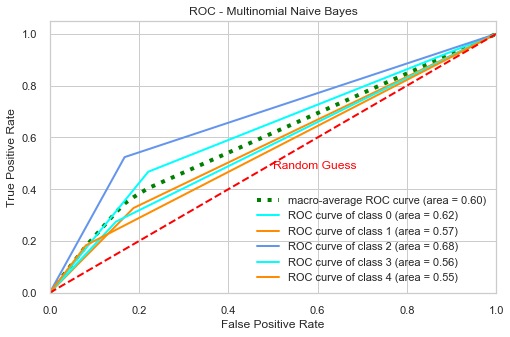

In [65]:
title = 'Multinomial Naive Bayes'
model = MultinomialNB()
SPLIT = 0.3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=SPLIT)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc_score = accuracy_score(y_test, y_pred)

roc_aus = multiclass_roc_auc_score(title, score, y_test, y_pred)
name.append(title)
score.append(roc_aus)
roc_multiclass (title, acc_score, y_pred, y_test)

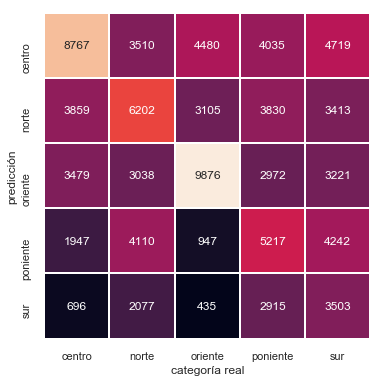

In [66]:
confusion_matrix_report(y_test, y_pred, classes)

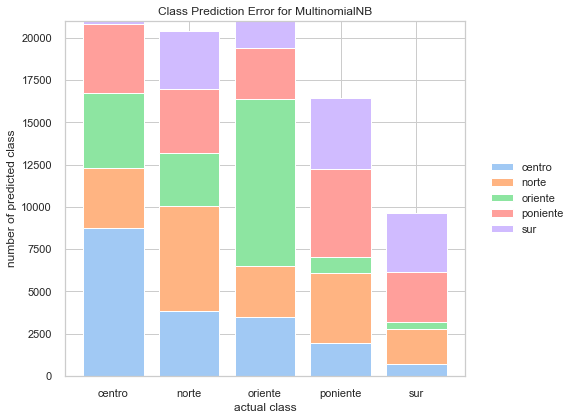

In [67]:
seleccion_visual_modelo_error(X_train, y_train, X_test, y_test, model, classes)

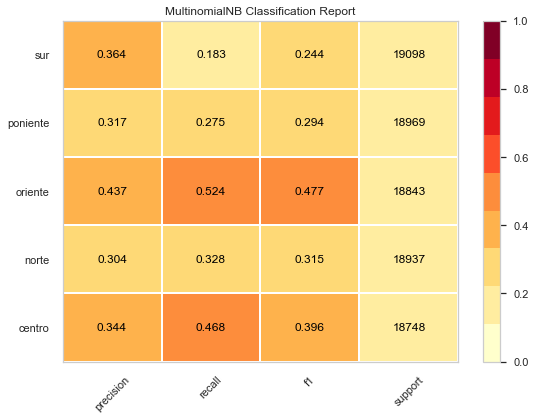

In [68]:
seleccion_visual_modelo_report(X_train, y_train, X_test, y_test, model, classes)

`El resultado aún no es de los mejores, pero se observa un mejor balance entre las prediciones. Vale hacer testes con otros modelos.`

### DECISION TREES

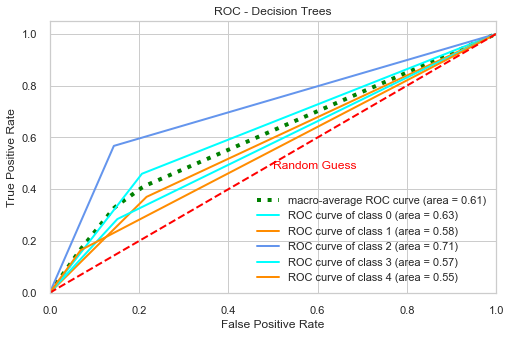

In [69]:
title = "Decision Trees"
model = DecisionTreeClassifier() 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

acc_score = accuracy_score(y_test, y_pred)
roc_aus = multiclass_roc_auc_score(title, score, y_test, y_pred)
name.append(title)
score.append(roc_aus)
roc_multiclass (title, acc_score, y_pred, y_test)

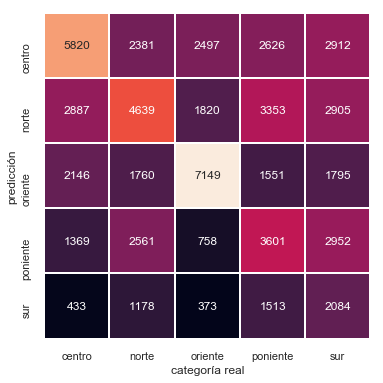

In [70]:
confusion_matrix_report(y_test, y_pred, classes)

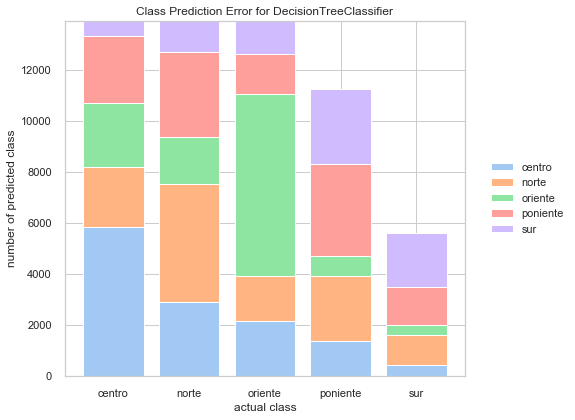

In [71]:
seleccion_visual_modelo_error(X_train, y_train, X_test, y_test, model, classes)

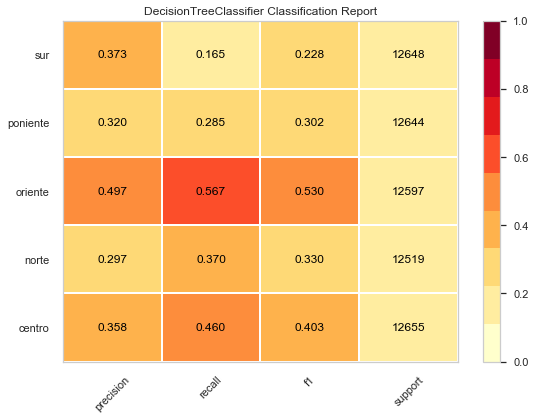

In [72]:
seleccion_visual_modelo_report(X_train, y_train, X_test, y_test, model, classes)

### RANDON FOREST

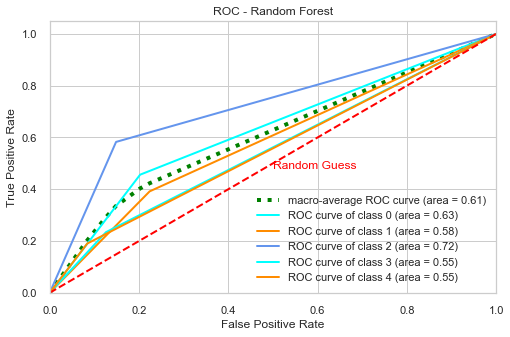

In [73]:
title = "Random Forest"
model = RandomForestClassifier(n_estimators=20, criterion='gini')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

acc_score = accuracy_score(y_test, y_pred)
roc_aus = multiclass_roc_auc_score(title, score, y_test, y_pred)
name.append(title)
score.append(roc_aus)
roc_multiclass (title, acc_score, y_pred, y_test)

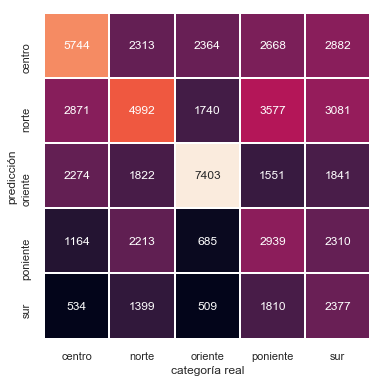

In [74]:
confusion_matrix_report(y_test, y_pred, classes)

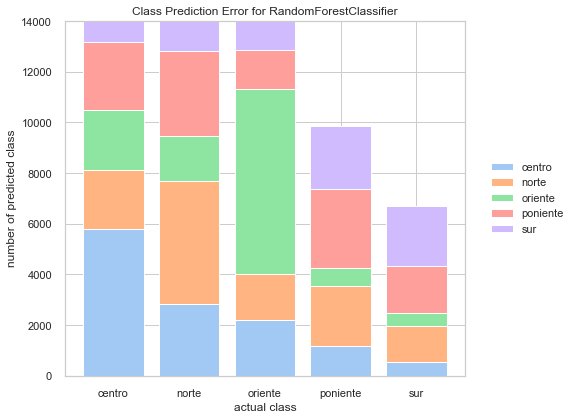

In [75]:
seleccion_visual_modelo_error(X_train, y_train, X_test, y_test, model, classes)

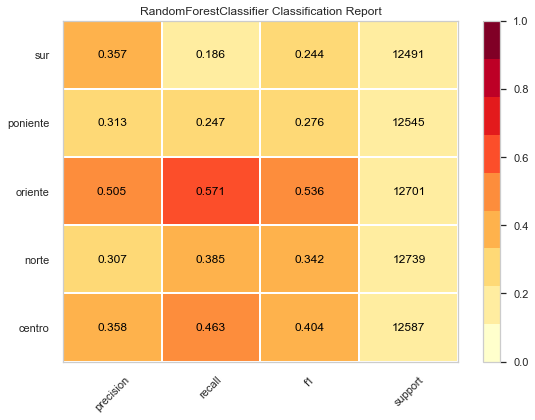

In [76]:
seleccion_visual_modelo_report(X_train, y_train, X_test, y_test, model, classes)

### LOGISTIC REGRESSION

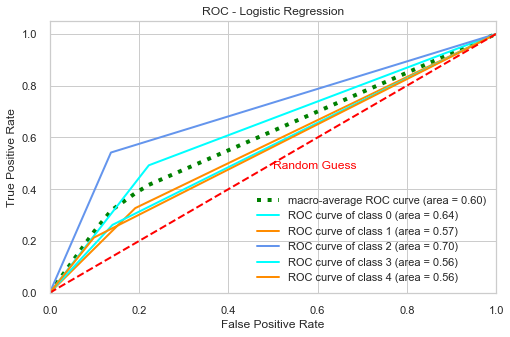

In [77]:
title = "Logistic Regression"
model = LogisticRegression(solver='lbfgs', multi_class='multinomial')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

acc_score = accuracy_score(y_test, y_pred)
roc_aus = multiclass_roc_auc_score(title, score, y_test, y_pred)
name.append(title)
score.append(roc_aus)
roc_multiclass (title, acc_score, y_pred, y_test)

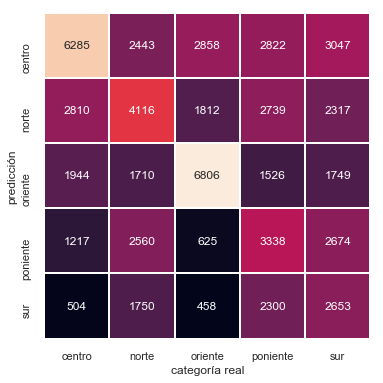

In [78]:
confusion_matrix_report(y_test, y_pred, classes)

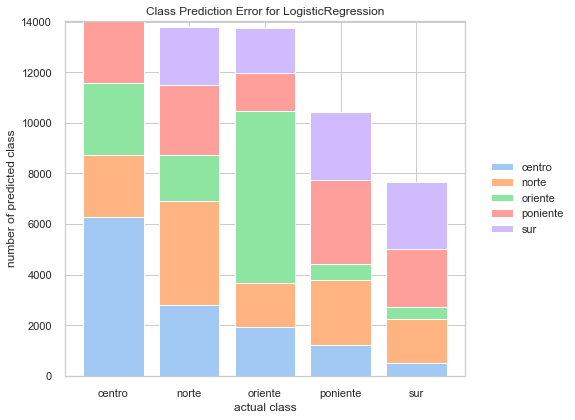

In [79]:
seleccion_visual_modelo_error(X_train, y_train, X_test, y_test, model, classes)

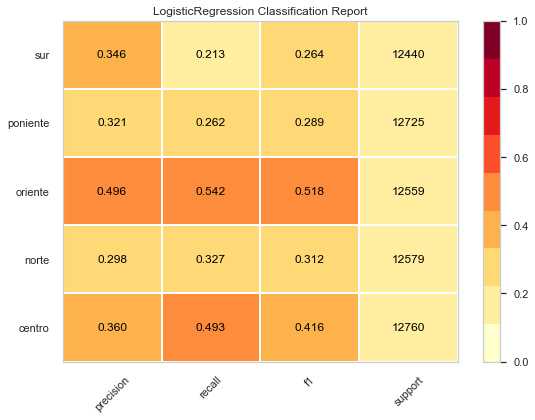

In [80]:
seleccion_visual_modelo_report(X_train, y_train, X_test, y_test, model, classes)

## SVM

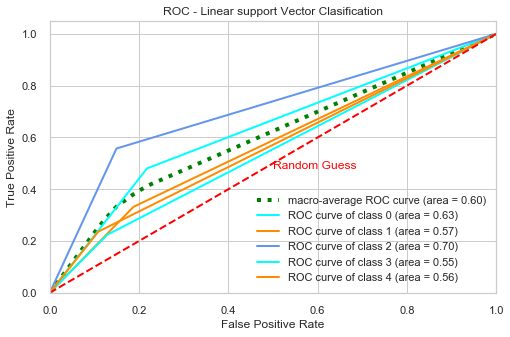

In [81]:
title = "Linear support Vector Clasification"
model = LinearSVC(random_state=0, tol=1e-5)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

acc_score = accuracy_score(y_test, y_pred)
roc_aus = multiclass_roc_auc_score(title, score, y_test, y_pred)
name.append(title)
score.append(roc_aus)
roc_multiclass (title, acc_score, y_pred, y_test)

In [82]:
model.coef_.shape

(5, 41)

In [83]:
model.intercept_

array([-0.41595728, -0.44113107,  0.08445186, -0.41484586, -0.36269098])

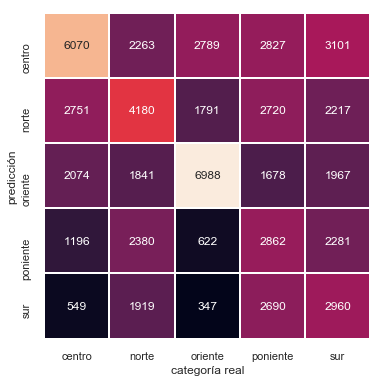

In [84]:
confusion_matrix_report(y_test, y_pred, classes)

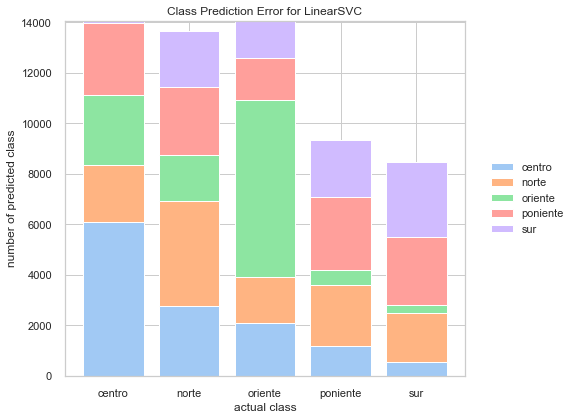

In [85]:
seleccion_visual_modelo_error(X_train, y_train, X_test, y_test, model, classes)

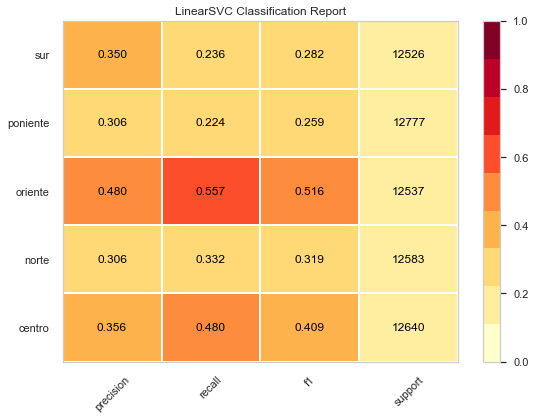

In [86]:
seleccion_visual_modelo_report(X_train, y_train, X_test, y_test, model, classes)

### Comparar "ROC-AUC"

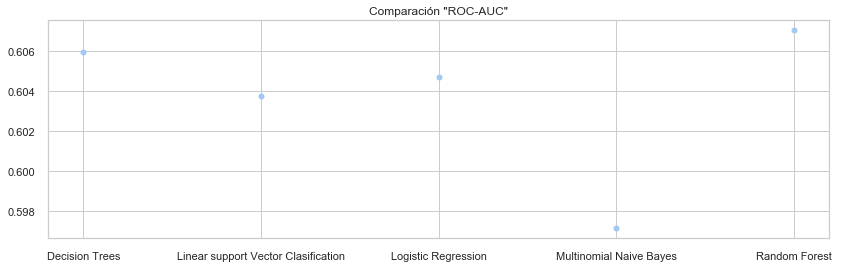

In [87]:
plt.figure(figsize = (14, 4))
plt.plot(name, score, 'bo')
plt.title('Comparación "ROC-AUC"');

`Los modelos no se diferenciaron mucho, pero se puede considerar como el mejor rsultado, el obtenido con el modelo "Random Forest". Además Random Forest es un modelo sencillo y rápido. El peor resultado es para el setor "Sur", sendo que para los demás está razonable. Vale la pena ver se es posible encontrar mejores parametros para el modelo. Para esto, usaremos la herramienta GridSearchCV`

### Encontrar los mejores parametros para el mejor modelo (Random Forest)

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [114]:
param_grid = { 
    'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [115]:
grid = GridSearchCV(RandomForestClassifier(random_state=0), param_grid=param_grid, cv= 5)

In [116]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf='deprecated', min_samples_split=2,
            min_weight_fraction_leaf='deprecated', n_estimators='warn',
            n_jobs=None, oob_score=False, random_state=0, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [100, 200, 500], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [4, 5, 6, 7, 8], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

`Los mejores parametros encontrados:`

In [118]:
grid.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'log2',
 'n_estimators': 100}

`Definir el modelo basado en los mejores parametros:`

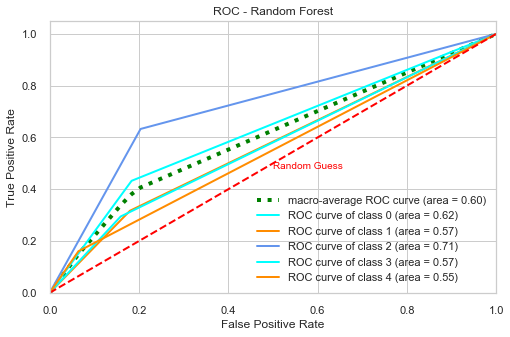

In [119]:
model = grid.best_estimator_
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

acc_score = accuracy_score(y_test, y_pred)
roc_aus = multiclass_roc_auc_score(title, score, y_test, y_pred)
name.append(title)
score.append(roc_aus)
roc_multiclass (title, acc_score, y_pred, y_test)

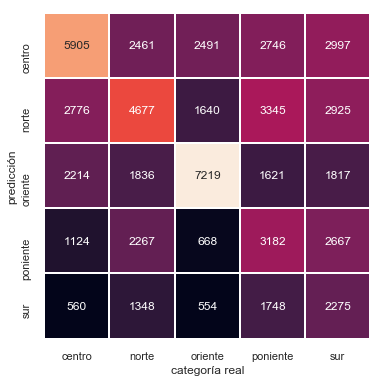

In [93]:
confusion_matrix_report(y_test, y_pred, classes)

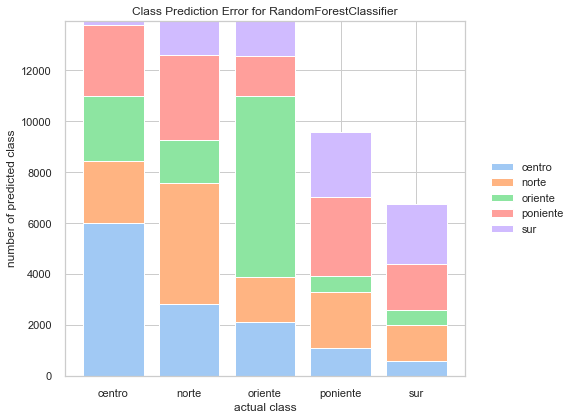

In [94]:
seleccion_visual_modelo_error(X_train, y_train, X_test, y_test, model, classes)

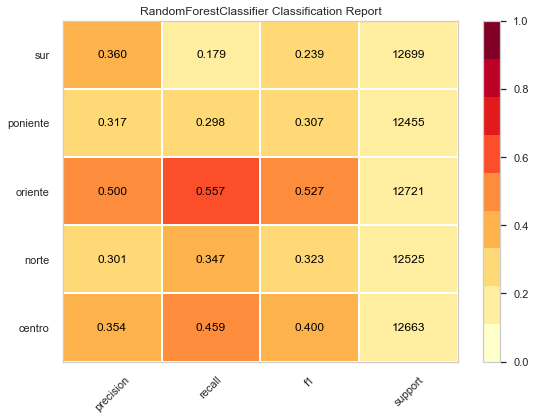

In [91]:
seleccion_visual_modelo_report(X_train, y_train, X_test, y_test, model, classes)

## Conclusión
`La idea original fue a partir de la data de los inmigrantes tales como edad, pais de origen, educación, actividad, etc., clasificar estes inmigrantes por sus comunas preferidadas en la Region Metropolitana. Este trabajo llevó en consideración modelos de clasificación supervisionados multi-class, pues al final se optó por 5 clases distintas, una para cada setor de da RM (Norte, Sur, Poniente, Oriente y Centro). Estes setores hacen sentido, pues durante las análisis de los datos (Notebook '02-analisis-datos'), quedó claro que existe mucha correlación entre los extranjeros que habitan un dado sector (ejemplo: no hace mucha diferencia la comuna del setor oriente donde se ubique el extranjero). Como el dataset posue un numero significativo de datos, se hizo un re-sampling ('Subsampling'), de manera a balancear la amuestra de datos para cada uno de las clases (en un primero intento, antes del balanceamanto, el resultado fue muy malo pues los datos posuían un siesgo importante, con algunos setores mucho mas populados que otros).`

`La gran mayoria de los datos eran categóricos, excepto por el año de la obtención del benefício y la edad del extranjero al obtenerlo. En estos dos ultimos casos se optó por también pasarlos a categóricos, definindo rangos de edad y año de obtención del benefício. Para los datos categóricos entonces se aplicó la tecnica 'OneHotEncoder' (excepto para sexo).`  

`Una vez con los datos todos codificados (numéricos), se procedió al split entre treinamiento y teste y aplicación de diferentes algorítmos de clasificación multi-class. Los resultados fueron similares. Tomandose Random Forest que fue el algorítmo com mejor average ROC-AUC score (aprox 0.61), se aplicó tecnicas para encontrar el mejor conjunto de parametros (GridSearch), pero el resultado final quedó en la misma.` 